In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from tqdm import tqdm


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 23
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
!pip freeze > requirements.txt

In [3]:
data = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v2.json', lines=True)
data.head()

data = data.sample(n=1000)

In [4]:
data.category.unique()

array(['BLACK VOICES', 'GREEN', 'ENTERTAINMENT', 'IMPACT',
       'HEALTHY LIVING', 'QUEER VOICES', 'DIVORCE', 'SPORTS',
       'ARTS & CULTURE', 'POLITICS', 'MEDIA', 'THE WORLDPOST', 'WEDDINGS',
       'WELLNESS', 'PARENTS', 'COLLEGE', 'GOOD NEWS', 'BUSINESS',
       'FOOD & DRINK', 'WORLDPOST', 'RELIGION', 'STYLE', 'FIFTY',
       'TRAVEL', 'HOME & LIVING', 'SCIENCE', 'WOMEN', 'CRIME', 'TECH',
       'COMEDY', 'ARTS', 'ENVIRONMENT', 'EDUCATION', 'WORLD NEWS',
       'STYLE & BEAUTY', 'PARENTING', 'LATINO VOICES', 'WEIRD NEWS',
       'TASTE', 'CULTURE & ARTS', 'MONEY'], dtype=object)

In [5]:
text = pd.DataFrame({
    'text':data.headline + data.short_description,
    'label':data.category
})

In [6]:
text.head()

,text,label
67604,Don Cheadle Is Miles Davis In 'Miles Ahead' Tr...,BLACK VOICES
151101,I Don't See Murder HereContrary to what George...,BLACK VOICES
103267,2015 Climate Change ForecastI'm pretty sure th...,GREEN
5159,Mark Hamill Confirms Hollywood Star News By Zi...,ENTERTAINMENT
101069,MTV's Bold MLK Day Move Will Be One You Won't ...,BLACK VOICES


In [7]:
encoder = LabelEncoder()
text.label = encoder.fit_transform(text.label)

text.head()

,text,label
67604,Don Cheadle Is Miles Davis In 'Miles Ahead' Tr...,2
151101,I Don't See Murder HereContrary to what George...,2
103267,2015 Climate Change ForecastI'm pretty sure th...,15
5159,Mark Hamill Confirms Hollywood Star News By Zi...,10
101069,MTV's Bold MLK Day Move Will Be One You Won't ...,2


In [8]:
train, test = train_test_split(text, test_size=0.1, random_state=23)
train, val = train_test_split(train, test_size=0.3,random_state=23)

In [9]:
# train.reset_index(drop=True, inplace=True)
# val.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)

In [10]:
# test.drop('label', 1, inplace=True)

## Tokenisation or data-preprocessing

In [11]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [12]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Sample Test

The idea is to preserve the purity of the sentence and not to convert it into all lower cases and vise-versa.

In [13]:
sample_txt = 'So give me reason to prove me wrong to wash this memory clean. Let the flood the cross the distance in your eyes.'

tokens = tokenizer.tokenize(sample_txt)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: So give me reason to prove me wrong to wash this memory clean. Let the flood the cross the distance in your eyes.
   Tokens: ['So', 'give', 'me', 'reason', 'to', 'prove', 'me', 'wrong', 'to', 'wash', 'this', 'memory', 'clean', '.', 'Let', 'the', 'flood', 'the', 'cross', 'the', 'distance', 'in', 'your', 'eyes', '.']
Token IDs: [1573, 1660, 1143, 2255, 1106, 5424, 1143, 2488, 1106, 10124, 1142, 2962, 4044, 119, 2421, 1103, 7870, 1103, 2771, 1103, 2462, 1107, 1240, 1257, 119]


Bert uses special tokens to navigate through the training process. The tokens include:
1. Unknown
2. Seperate
3. Padding
4. Class
5. Mask

In [14]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [15]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)


encoding.keys()



dict_keys(['input_ids', 'attention_mask'])

In [16]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'So',
 'give',
 'me',
 'reason',
 'to',
 'prove',
 'me',
 'wrong',
 'to',
 'wash',
 'this',
 'memory',
 'clean',
 '.',
 'Let',
 'the',
 'flood',
 'the',
 'cross',
 'the',
 'distance',
 'in',
 'your',
 'eyes',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [17]:
class Tokenisation(Dataset):
    
    
    def __init__(self, data, targets, tokenizer, max_len):
        self.data = data
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pad_vid = self.tokenizer.vocab["[PAD]"]
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        data = str(self.data[item])
        data = " ".join(data.split())
        target = self.targets
        
        encoding = self.tokenizer.encode_plus(
          data,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        
        ids = encoding['input_ids']
        masks = encoding['attention_mask']
        token_type_ids = encoding['input_ids']
        
        true_seq_length = len(encoding['input_ids'][0])
        pad_size = self.max_len - true_seq_length
        pad_ids = torch.Tensor([self.pad_vid] * pad_size).long()
        ids = torch.cat((encoding['input_ids'][0], pad_ids))
        
        
#         padding_len = self.max_len - len(ids)
#         ids = ids + ([0] * padding_len)
#         masks = ids + ([0] * padding_len)
#         token_type_ids = token_type_ids + ([0] * padding_len)
        
        return {
          'text': data,
          'input_ids': ids.flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target[item], dtype=torch.long)
        }

In [18]:
def dataLoader(df, tokenizer, max_len, batch_size):
    ds = Tokenisation(
    data=df['text'].to_numpy(),
    targets=df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
    )
    return DataLoader(ds,batch_size=batch_size, num_workers=4)

In [19]:
BATCH_SIZE = 16
MAX_LEN = 128

train_data_loader = dataLoader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = dataLoader(val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = dataLoader(test, tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [21]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


## Building the model

In [22]:
class TextClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(TextClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
            
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)
    
    def unfreeze(self,start_layer,end_layer):
        def children(m):
            return m if isinstance(m, (list, tuple)) else list(m.children())
        def set_trainable_attr(m, b):
            m.trainable = b
            for p in m.parameters():
                p.requires_grad = b
        def apply_leaf(m, f):
            c = children(m)
            if isinstance(m, nn.Module):
                f(m)
            if len(c) > 0:
                for l in c:
                    apply_leaf(l, f)
        def set_trainable(l, b):
            apply_leaf(l, lambda m: set_trainable_attr(m, b))

        # You can unfreeze the last layer of bert by calling set_trainable(model.bert.encoder.layer[23], True)
        set_trainable(self.bert, False)
        for i in range(start_layer, end_layer+1):
            set_trainable(self.bert.encoder.layer[i], True)

In [23]:
device

device(type='cuda', index=0)

In [24]:
len(text.label.unique())

41

In [25]:
model = TextClassifier(len(text.label.unique()))
model = model.to(device)

In [26]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 128])
torch.Size([16, 128])


In [27]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0625, 0.0129, 0.0152, 0.0174, 0.0173, 0.0215, 0.0164, 0.0333, 0.0364,
         0.0277, 0.0327, 0.0216, 0.0321, 0.0109, 0.0195, 0.0247, 0.0165, 0.0193,
         0.0186, 0.0056, 0.0272, 0.0253, 0.0560, 0.0120, 0.0264, 0.0440, 0.0081,
         0.0298, 0.0166, 0.0495, 0.0497, 0.0125, 0.0242, 0.0192, 0.0079, 0.0152,
         0.0291, 0.0188, 0.0246, 0.0244, 0.0172],
        [0.0588, 0.0104, 0.0262, 0.0129, 0.0107, 0.0205, 0.0182, 0.0218, 0.0342,
         0.0586, 0.0237, 0.0186, 0.0189, 0.0126, 0.0168, 0.0167, 0.0257, 0.0463,
         0.0153, 0.0075, 0.0275, 0.0342, 0.0631, 0.0269, 0.0098, 0.0197, 0.0127,
         0.0204, 0.0199, 0.0663, 0.0271, 0.0126, 0.0220, 0.0367, 0.0098, 0.0187,
         0.0297, 0.0272, 0.0115, 0.0101, 0.0200],
        [0.0463, 0.0062, 0.0242, 0.0096, 0.0102, 0.0153, 0.0246, 0.0245, 0.0173,
         0.0259, 0.0323, 0.0159, 0.0165, 0.0107, 0.0291, 0.0110, 0.0424, 0.0414,
         0.0188, 0.0041, 0.0358, 0.0759, 0.0552, 0.0304, 0.0207, 0.0388, 0.0114,
         

In [28]:
EPOCHS = 3
MAX_LENGTH = 128
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4

LearningRate = 5e-5

BETAS = (0.9, 0.999)
BERT_WEIGHT_DECAY = 0.01
EPS = 1e-8

# Define identifiers & group model parameters accordingly 
bert_identifiers = ['embedding', 'encoder', 'pooler']
no_weight_decay_identifiers = ['bias', 'LayerNorm.weight']
grouped_model_parameters = [
        {'params': [param for name, param in model.named_parameters()
                    if any(identifier in name for identifier in bert_identifiers) and
                    not any(identifier_ in name for identifier_ in no_weight_decay_identifiers)],
        'lr': LearningRate,
        'betas': BETAS,
        'weight_decay': BERT_WEIGHT_DECAY,
        'eps': EPS},
        {'params': [param for name, param in model.named_parameters()
                    if any(identifier in name for identifier in bert_identifiers) and
                    any(identifier_ in name for identifier_ in no_weight_decay_identifiers)],
        'lr': LearningRate,
        'betas': BETAS,
        'weight_decay': 0.0,
        'eps': EPS},
        {'params': [param for name, param in model.named_parameters()
                    if not any(identifier in name for identifier in bert_identifiers)],
        'lr': LearningRate,
        'betas': BETAS,
        'weight_decay': 0.0,
        'eps': EPS}
]

# Define optimizer
optimizers = AdamW(grouped_model_parameters)

optimizer = AdamW(model.parameters(), lr=5e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [29]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    
    
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [30]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    
    losses = []
    
    correct_predictions = 0
    
    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [31]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
                                        model,
                                        train_data_loader,
                                        loss_fn,
                                        optimizer,
                                        device,
                                        scheduler,
                                        len(train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
                                    model,
                                    val_data_loader,
                                    loss_fn,
                                    device,
                                    len(val)
  )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/3
----------


  0%|          | 0/17 [00:00<?, ?it/s]

Train loss 3.4384309232234953 accuracy 0.15396825396825398


100%|██████████| 17/17 [00:01<00:00, 11.92it/s]


Val   loss 3.184098117491778 accuracy 0.17777777777777778



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/3
----------


  0%|          | 0/17 [00:00<?, ?it/s]

Train loss 3.003366583585739 accuracy 0.25396825396825395


100%|██████████| 17/17 [00:01<00:00, 11.44it/s]


Val   loss 2.9439484792597153 accuracy 0.26666666666666666



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/3
----------


  0%|          | 0/17 [00:00<?, ?it/s]

Train loss 2.664821594953537 accuracy 0.3476190476190476


100%|██████████| 17/17 [00:01<00:00, 11.79it/s]


Val   loss 2.8026052082286164 accuracy 0.31851851851851853

CPU times: user 21.2 s, sys: 9.62 s, total: 30.9 s
Wall time: 34.1 s


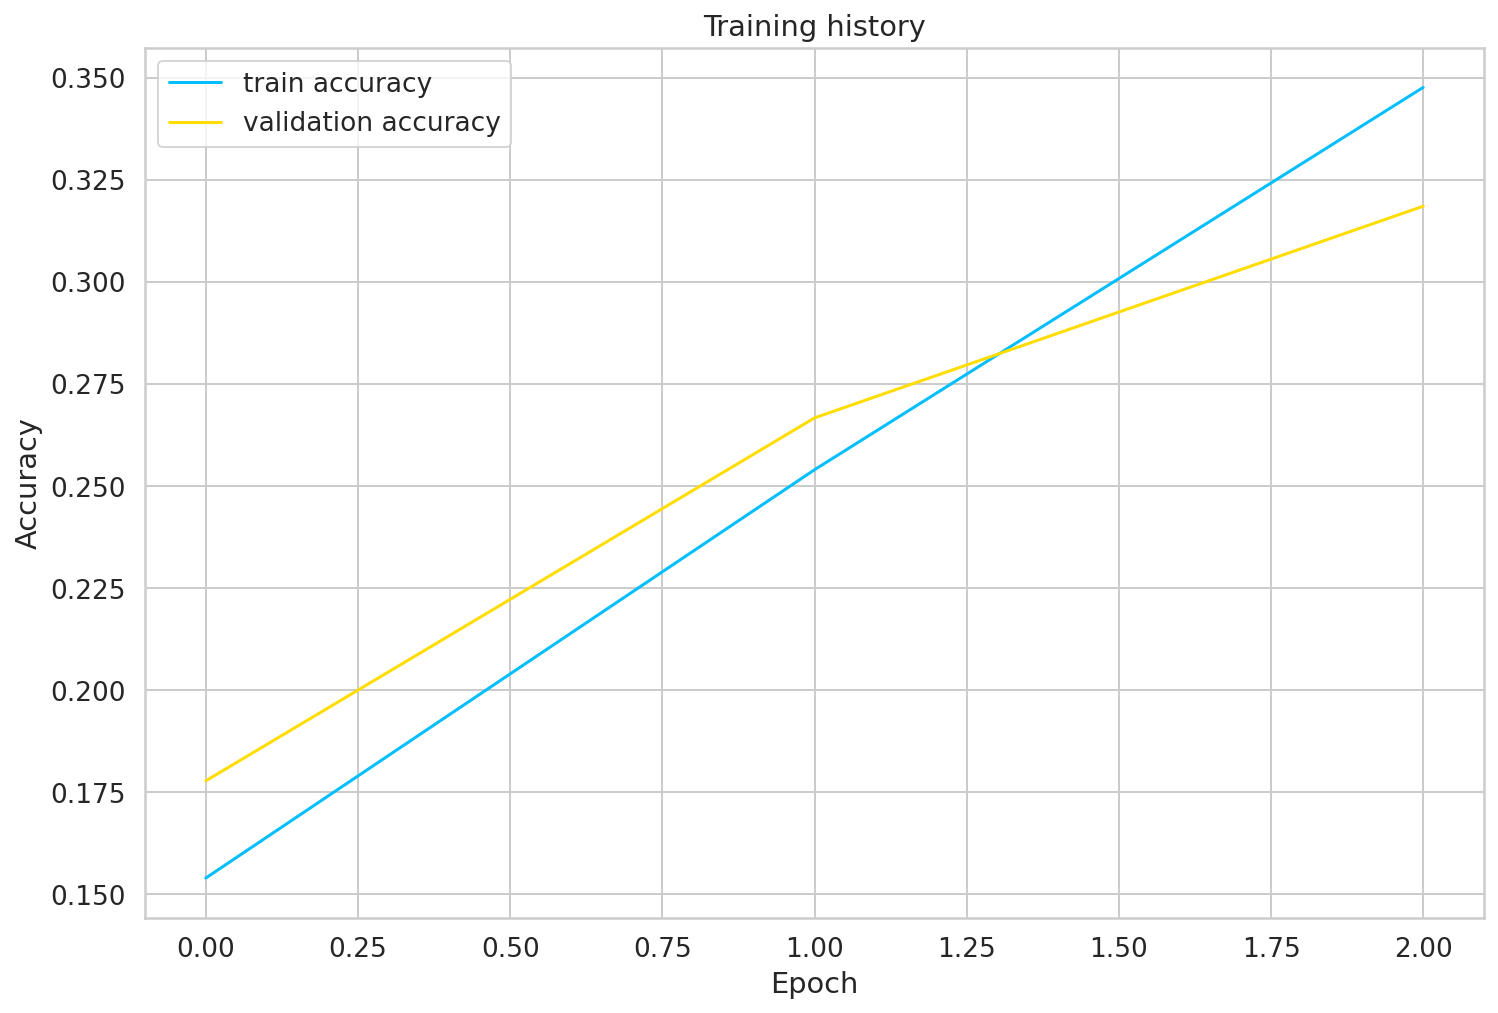

In [32]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [33]:
test

,text,label
177549,"Palmdale, Florida: Biggest Bite Per Capita (PH...",34
165427,Unstick Drawers Using...A Bar Of Soap?** Have ...,17
33665,Dakota Access Protesters Arrested As Deadline ...,24
138323,"""It's All Feelings, Baby!"" - How Is This Refle...",30
138716,"A Man, a Turkey: Thanksgiving UnpluggedI hereb...",37
...,...,...
6026,"The First 'Venom' Trailer Is Here, And Spider-...",10
95592,Tim Tebow Trained With Manny PacquiaoThe pair ...,28
140150,How to Write a Condolence Letter: 5 Suggestion...,37
138201,Thick Thighs and Paris Street FoodMy nose was ...,34


In [34]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)


test_acc.item()

NameError: name 'df_test' is not defined

In [35]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
    for d in data_loader:
        texts = d["review_text"]
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        review_texts.extend(texts)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

IndentationError: expected an indented block (<ipython-input-35-cc4515d43628>, line 8)

In [36]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

NameError: name 'get_predictions' is not defined

In [37]:
print(classification_report(y_test, y_pred, target_names=class_names))

NameError: name 'y_test' is not defined

In [38]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

In [39]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

NameError: name 'y_test' is not defined